In [3]:
import snscrape.modules.twitter as sntwitter #Used snscrape to pull old tweets
import pandas as pd
import numpy as np
import string

import re
import requests

from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emot.emo_unicode import EMOTICONS_EMO

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from tqdm.notebook import tqdm

#from transformers import pipeline
#roberta_pipeline = pipeline('sentiment-analysis')

from textblob import TextBlob 
from textblob.sentiments import NaiveBayesAnalyzer
nav_bayes = NaiveBayesAnalyzer()

In [4]:
# Creating list to append tweet data to
tweets_list = []

# Using TwitterSearchScraper to scrape data from 2022-05-05 till 2022-06-05 (1 month) and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('apex legends mobile since:2020-05-05 until:2022-06-22').get_items()):
    tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username, 
                         tweet.user.location, tweet.lang, tweet.retweetCount, tweet.likeCount])

In [5]:
df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Location', 'Language',
                                               'Retweets', 'Likes'])

In [6]:
df.head()

,Datetime,Tweet Id,Text,Username,Location,Language,Retweets,Likes
0,2022-06-21 23:58:26+00:00,1539397364238237696,@mark34198348 @PlayApexMobile I just don’t und...,LarryMVols18,"Atlanta, GA",en,0,0
1,2022-06-21 23:57:33+00:00,1539397142183391232,@mark34198348 @PlayApexMobile Hell no I use my...,LarryMVols18,"Atlanta, GA",en,0,0
2,2022-06-21 23:54:52+00:00,1539396463108792322,@Kauzeyy @PlayApexMobile YOOO CHILL 🤣🤣🤣,IzzyBonesGaming,,es,0,0
3,2022-06-21 23:53:39+00:00,1539396156790394880,@ImOwFromYT @Respawn @PlayApexMobile my shii i...,fayde990,,en,0,1
4,2022-06-21 23:53:22+00:00,1539396086179287041,The developers at @Respawn and @PlayApexMobile...,Hyper_FNM,,en,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107503 entries, 0 to 107502
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   Datetime  107503 non-null  datetime64[ns, UTC]
 1   Tweet Id  107503 non-null  int64              
 2   Text      107503 non-null  object             
 3   Username  107503 non-null  object             
 4   Location  107503 non-null  object             
 5   Language  107503 non-null  object             
 6   Retweets  107503 non-null  int64              
 7   Likes     107503 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 6.6+ MB


In [8]:
df['Language'].value_counts()

en     75864
ja      6924
es      5875
fr      3089
und     2985
in      2839
pt      2561
qme     1522
ro       825
qam      761
tl       685
tr       526
de       441
ar       402
it       308
th       229
hi       208
ru       179
pl       142
nl       124
ht       120
cs       116
da       113
sv       106
et        80
zh        74
vi        67
ca        55
fa        45
eu        43
no        36
cy        35
lt        22
hu        20
fi        13
lv        11
sl        11
is         8
ko         8
uk         7
el         6
ta         4
qht        4
bg         3
hy         1
km         1
ml         1
mr         1
my         1
lo         1
am         1
Name: Language, dtype: int64

In [9]:
#Creating a dataframe to store only english tweets
tweets_df = df[df['Language'] == 'en']
tweets_df.reset_index(drop=True, inplace=True)

In [10]:


#Creating a location dataframe to store top 50 location values
location_df = pd.DataFrame(tweets_df.loc[:, 'Location'].value_counts().head(50))\
                .reset_index()\
                .reset_index()\
                .rename(columns={'level_0':'id', 'index':'location', 'Location':'counts'})



In [11]:
#Here api was used to get the city and country values
URL = "https://geocoder.ls.hereapi.com/search/6.2/geocode.json"
api_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'  # Acquire api key from developer.here.com

def getCoordinates(location):
    PARAMS = {'searchtext': location, 'apikey': api_key} # required parameters
    r = requests.get(url=URL, params=PARAMS)  # pass in required parameters
    data = r.json() # Raw json file
    try:
        label = data['Response']['View'][0]['Result'][0]['Location']['Address']['City']
        country = data['Response']['View'][0]['Result'][0]['Location']['Address']['Country']
        return label, country
    except:
        return 'Unknown', 'Unknown'

#You can also use geopy to do this
#from geopy.geocoders import Nominatim
#from geopy.extra.rate_limiter import RateLimiter
#import geopy
 
# calling the nominatim tool
#geopy.geocoders.options.default_user_agent = "GetLoc"
#loc = Nominatim(user_agent="GetLoc")
#geocode = RateLimiter(loc.geocode, min_delay_seconds=0)

In [12]:
#Tqdm was used for the progress bar and the result is stored in the hereloc dictionary
hereloc = {}

for i, row in tqdm(location_df.iterrows(), total=len(location_df), miniters=1):    
    myid = row['id']
    locate = row['location']
    
    label, country_code = getCoordinates(locate)
    #country_code = geocode(locate) --Like stated above, geocode can also be used
    hereloc[myid] = [label, country_code]

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:

location_dict = pd.DataFrame.from_dict(hereloc, orient='index')\
                .reset_index()\
                .rename(columns={'index': 'id', 0: 'city', 1: 'country_code'})

location_data = location_df.merge(location_dict)



In [14]:
#Extracting top country and city from the location_data dataframe
country_count = location_data.groupby('country_code').sum()[['counts']].sort_values('counts', ascending=False).reset_index()
city_count = location_data.groupby('city').sum()[['counts']].sort_values('counts', ascending=False).reset_index()

Text(0, 1, 'Country Code')

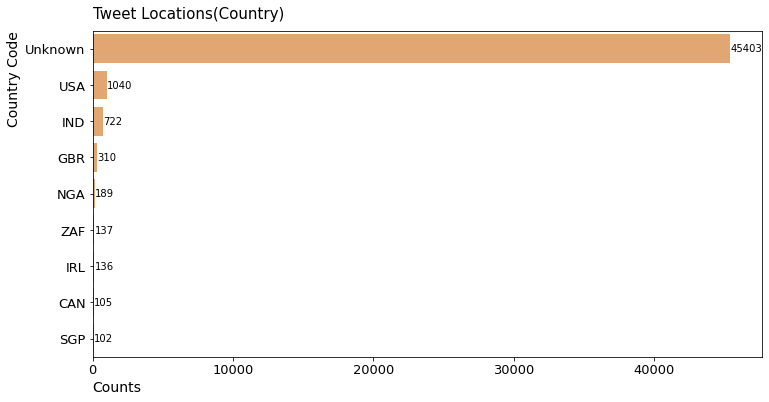

In [15]:
with plt.rc_context({'font.size':13}):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='counts', y='country_code', data = country_count, color='sandybrown')
    
plt.bar_label(ax.containers[0])
ax.set_title('Tweet Locations(Country)', fontdict={'fontsize':15}, loc='left', pad = 12)
ax.set_xlabel('Counts', fontdict={'fontsize':14}, loc='left')
ax.set_ylabel('Country Code', fontdict={'fontsize':14}, loc='top')

Text(0, 1, 'City')

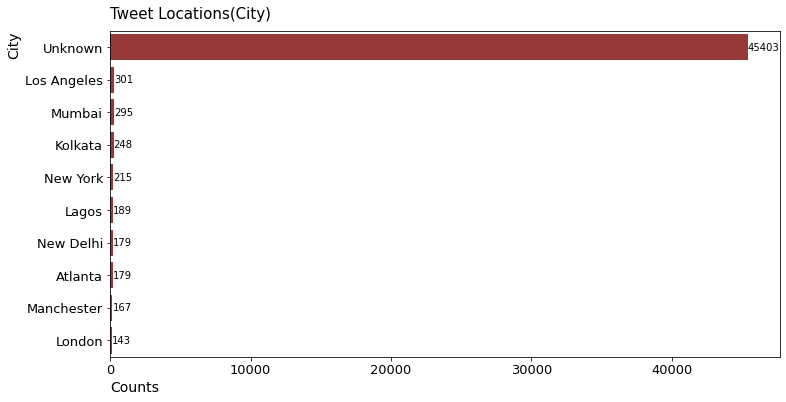

In [16]:
with plt.rc_context({'font.size':13}):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='counts', y='city', data = city_count.head(10), color='brown')
    
plt.bar_label(ax.containers[0])
ax.set_title('Tweet Locations(City)', fontdict={'fontsize':15}, loc='left', pad=12)
ax.set_xlabel('Counts', fontdict={'fontsize':14}, loc='left')
ax.set_ylabel('City', fontdict={'fontsize':14}, loc='top')

In [17]:
#A function to extract hashtags from a tweet
def hashtags(tweet):
    tweet = tweet.lower()
    tweet_regex = re.findall(r'#\w+', tweet)
    return ' '.join(tweet_regex)

In [18]:
#A function to extract mentioned users from a tweet
def mentions(tweet):
    tweet = tweet.lower()
    tweet_regex = re.findall(r'@\w+', tweet)
    return ' '.join(tweet_regex)

In [19]:
apexlegendsmobile_skins = ['Lifeline', 'octane', 'bangalore', 'caustic', 'mirage', 'octane', 'pathfinder', 'wraith', 'bloodhound', 'joe', 
                          'gibraltar', 'loba', 'fade']

In [20]:

def characters(tweet):
    tweet = tweet.lower()
    tweet_tokenize = word_tokenize(tweet)
    xter = [character for character in tweet_tokenize if character in apexlegendsmobile_skins]
    return ' '.join(xter)



In [21]:
tweets_df['Hashtags'] = tweets_df.loc[:, 'Text'].apply(hashtags)



C:\Users\User\AppData\Local\Temp\ipykernel_10660\517769273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['Hashtags'] = tweets_df.loc[:, 'Text'].apply(hashtags)


In [22]:
tweets_df['MentionedUsers'] = tweets_df.loc[:, 'Text'].apply(mentions)
tweets_df['Characters'] = tweets_df.loc[:, 'Text'].apply(characters)

C:\Users\User\AppData\Local\Temp\ipykernel_10660\2647512342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['MentionedUsers'] = tweets_df.loc[:, 'Text'].apply(mentions)


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\User/nltk_data'
    - 'C:\\Users\\User\\anaconda3\\nltk_data'
    - 'C:\\Users\\User\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\User\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\User\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [23]:
tweets_df.head(10)

,Datetime,Tweet Id,Text,Username,Location,Language,Retweets,Likes,Hashtags,MentionedUsers
0,2022-06-21 23:58:26+00:00,1539397364238237696,@mark34198348 @PlayApexMobile I just don’t und...,LarryMVols18,"Atlanta, GA",en,0,0,,@mark34198348 @playapexmobile
1,2022-06-21 23:57:33+00:00,1539397142183391232,@mark34198348 @PlayApexMobile Hell no I use my...,LarryMVols18,"Atlanta, GA",en,0,0,,@mark34198348 @playapexmobile
2,2022-06-21 23:53:39+00:00,1539396156790394880,@ImOwFromYT @Respawn @PlayApexMobile my shii i...,fayde990,,en,0,1,,@imowfromyt @respawn @playapexmobile
3,2022-06-21 23:53:22+00:00,1539396086179287041,The developers at @Respawn and @PlayApexMobile...,Hyper_FNM,,en,0,1,,@respawn @playapexmobile
4,2022-06-21 23:45:08+00:00,1539394013681356800,@DeathlyAPXM @1ceStream @PlayApexMobile ping,zoeticfnm,,en,0,0,,@deathlyapxm @1cestream @playapexmobile
5,2022-06-21 23:43:28+00:00,1539393595391844352,Oh @PlayApexMobile is done done.. 5 minutes to...,ZayP30,"Texas, USA",en,0,0,#stopitapex,@playapexmobile
6,2022-06-21 23:42:02+00:00,1539393235428249601,@CalistusYT @PlayApexMobile I think he’s legit 🐒,GolemSlayer1234,Shin-Sekaï,en,0,0,,@calistusyt @playapexmobile
7,2022-06-21 23:37:36+00:00,1539392117788712960,@LarryMVols18 @PlayApexMobile You can play wit...,mark34198348,,en,0,0,,@larrymvols18 @playapexmobile
8,2022-06-21 23:36:01+00:00,1539391720282103809,@PlayApexMobile I’m curious why do players use...,LarryMVols18,"Atlanta, GA",en,0,1,,@playapexmobile
9,2022-06-21 23:28:50+00:00,1539389914864926720,📌YouTube Rating 5/5 : #apexlegends #mobile Whe...,USStockCryptoN2,Tokyo,en,0,0,#apexlegends #mobile,


In [24]:
tweets_df.to_csv('nameoff2.csv')